<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebooks-settings-and-libraries" data-toc-modified-id="Notebooks-settings-and-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebooks settings and libraries</a></span><ul class="toc-item"><li><span><a href="#Notebook-magic" data-toc-modified-id="Notebook-magic-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Notebook magic</a></span></li><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Plotting-style" data-toc-modified-id="Plotting-style-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plotting style</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Bayesian-modelling-in-PyMC3-with-bambi-interface" data-toc-modified-id="Bayesian-modelling-in-PyMC3-with-bambi-interface-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Bayesian modelling in PyMC3 with <a href="https://github.com/bambinos/bambi" target="_blank">bambi</a> interface</a></span><ul class="toc-item"><li><span><a href="#Set-up-the-model" data-toc-modified-id="Set-up-the-model-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Set up the model</a></span></li><li><span><a href="#Examine-plots" data-toc-modified-id="Examine-plots-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Examine plots</a></span></li></ul></li><li><span><a href="#Summary-table" data-toc-modified-id="Summary-table-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Summary table</a></span></li><li><span><a href="#Useful-references" data-toc-modified-id="Useful-references-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Useful references</a></span></li></ul></li></ul></div>

# Notebooks settings and libraries

## Notebook magic

In [3]:
%matplotlib inline

## Import libraries

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import pymc3 as pm
import theano
import bambi
import string

## Plotting style

In [8]:
plt.style.use('indigo-white')
sns.set_style('white')
palette = sns.color_palette()

/home/ubuntu/anaconda3/envs/pymc_env/lib/python3.6/site-packages/matplotlib/style/core.py:51: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


# Analysis

## Generate data

Parameters

In [1]:
var1 = 2 #Variance per treatment
var2 = 3 #Variance of the sampling distribution of the means
N1 = 100 #Number of points in one treatment
N2 = 20 #Number of treatments

Generate data

In [38]:
data = pd.DataFrame(dict([['treatment_{}'.format(string.ascii_lowercase[i]), 
                           np.random.normal(mu, var1**0.5, N1)] for i, mu in enumerate(np.random.normal(5, var2**0.5, N2))])
                   )
data = data.melt()

In [39]:
data.head()

,variable,value
0,treatment_a,2.270131
1,treatment_a,3.177015
2,treatment_a,3.596321
3,treatment_a,5.108631
4,treatment_a,3.472303


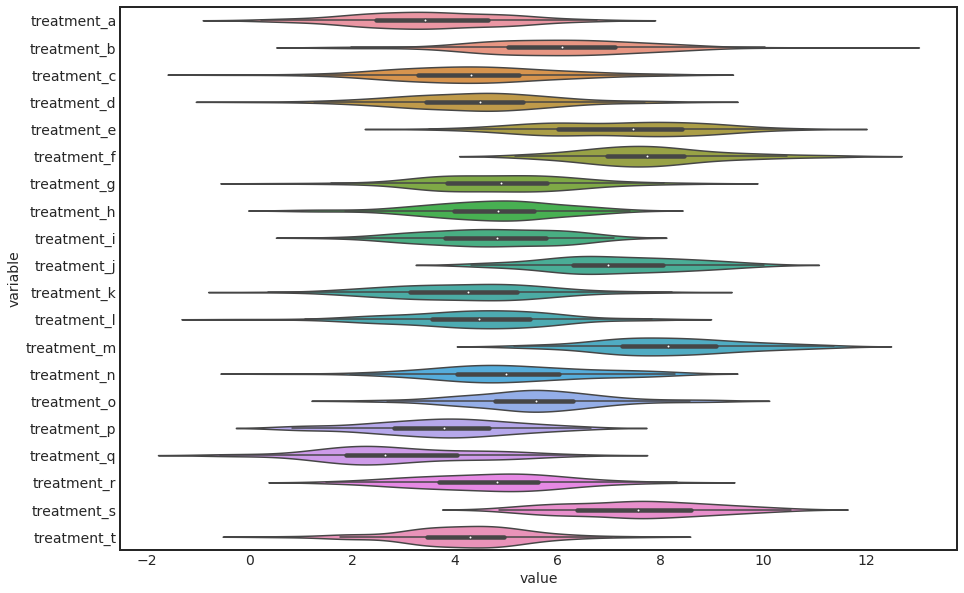

In [40]:
sns.violinplot(y = 'variable', x = 'value', data = data)

## Bayesian modelling in PyMC3 with [bambi](https://github.com/bambinos/bambi) interface

### Set up the model

Let's set up hierarchical linear model with response variable 'value' and group-level effects $\alpha_j$ defined by 'variable':

$$value_{j} \sim N(\alpha_j, \sigma^2_y)$$
$$\alpha_j \sim N(\mu, \sigma^2_\alpha)$$
$$\sigma_\alpha \sim N(\mu_\sigma, \sigma_\sigma)$$

where $\mu$, $\mu_\sigma$ and $\sigma_\sigma$ can be determined from the data as shown below.

In [41]:
#Initialize the model
model = bambi.Model(data)

#Define the model
model.add('value ~ 0 + variable'
         )

#Define priors on the slope and variance of the slope
sd_prior = bambi.Prior('Normal', 
                       mu = data.groupby('variable').std().mean(),
                      sd = data.groupby('variable').std().std()) #Normal distribution centered around average group standard deviation

slope_prior = bambi.Prior('Normal', 
                          mu=data.value.mean(), 
                          sd=sd_prior) #Normal distribution centered around all-data mean, assuming that all treatments are similar to each other

#Build the model
model.build(backend='pymc3')

/home/ubuntu/anaconda3/envs/pymc_env/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/ubuntu/anaconda3/envs/pymc_env/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [42]:
model.backend.model

Now that the model is compiled you can samplie using bambi interface...

In [43]:
#Sample
results = model.fit(samples=300, 
                    chains=4, 
                    priors = {'fixed': slope_prior},
                    nuts_kwargs=dict(target_accept=.9),
                    tune = 500
                   )

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 3,601.5:  27%|██▋       | 13281/50000 [00:08<00:19, 1884.00it/s]
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 4,206.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sd, variable]
Sampling 4 chains: 100%|██████████| 3200/3200 [00:08<00:00, 361.01draws/s]


...or PyMC3 directly

In [157]:
with model.backend.model:
    trace = pm.sample(300, cores=4, step = pm.NUTS())

Only 300 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sd, replica, treatment, Intercept]
Sampling 4 chains: 100%|██████████| 3200/3200 [00:35<00:00, 90.25draws/s] 
The number of effective samples is smaller than 25% for some parameters.


### Examine plots

Chains and posterior distributions. See [here](https://docs.pymc.io/api/plots.html) for more info on other plots implemented in PyMC3.

<Figure size 504x504 with 0 Axes>

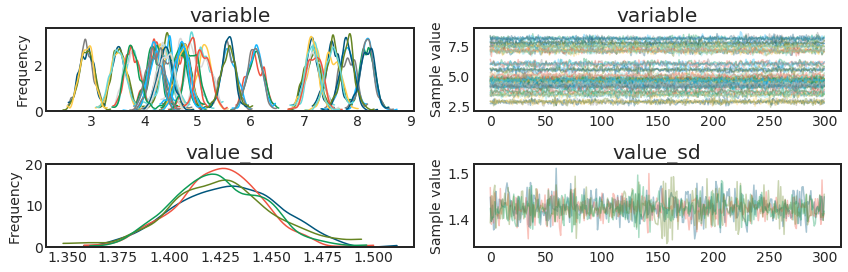

In [44]:
plt.figure(figsize=(7, 7))
pm.traceplot(model.backend.trace)
plt.tight_layout()

Posteriors with credible regions

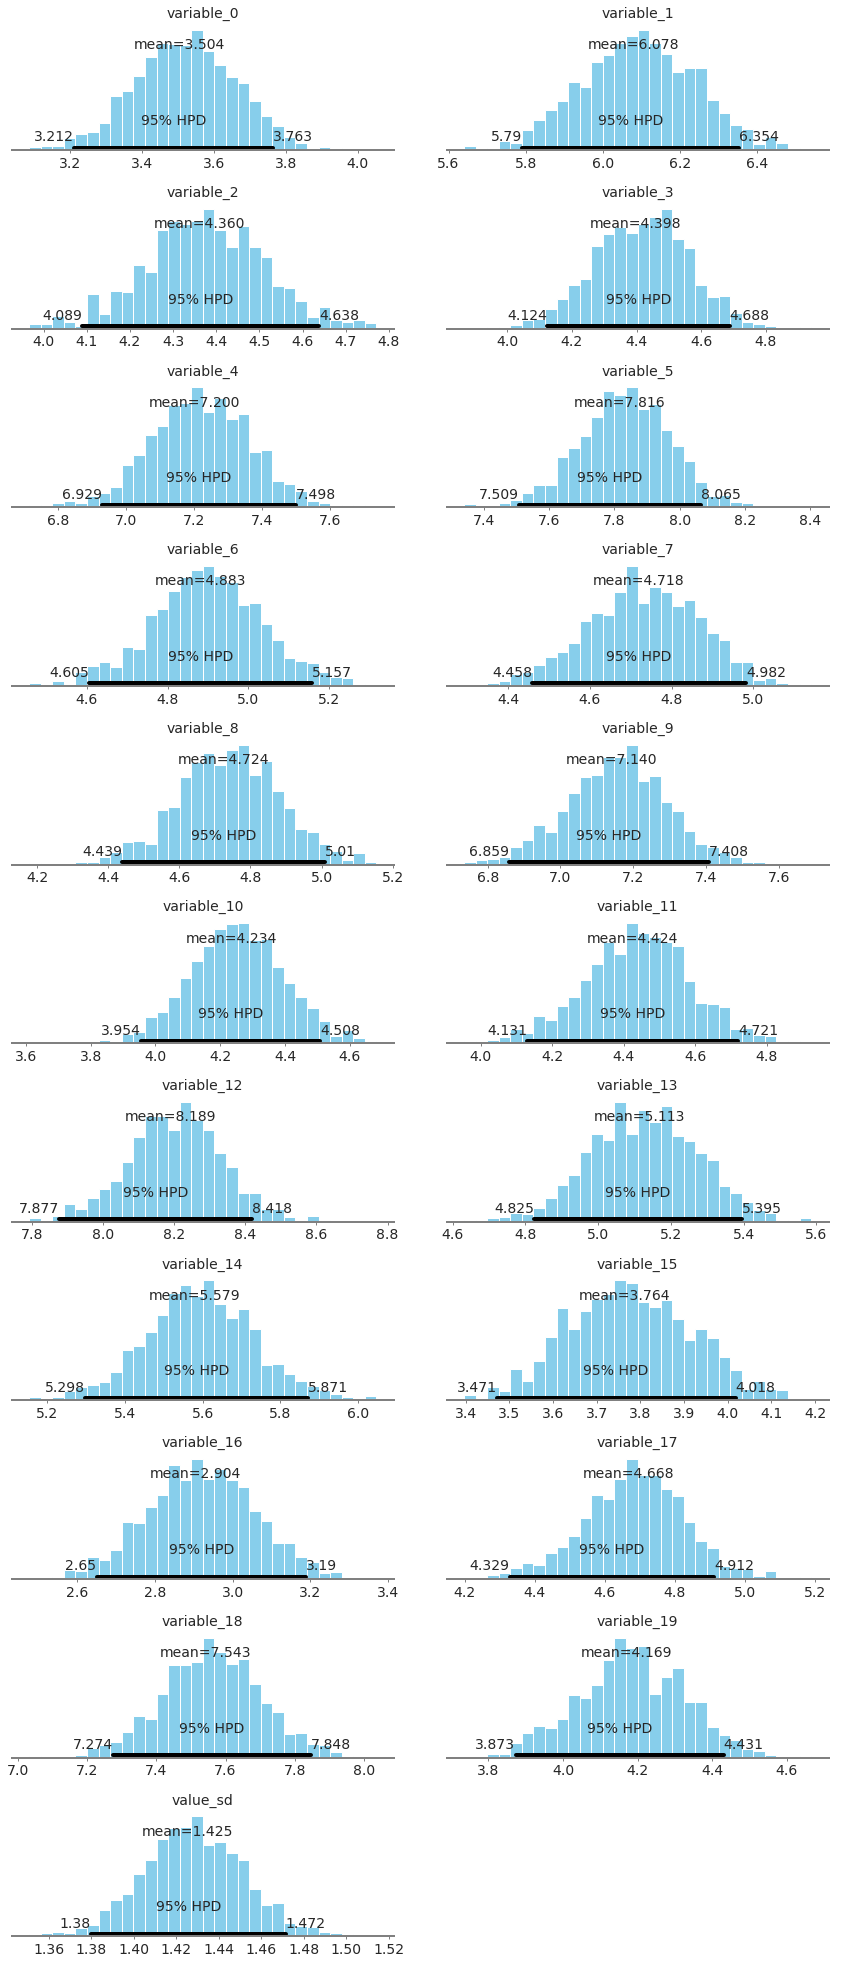

In [45]:
_ = pm.plot_posterior(model.backend.trace)

Chains autocorrelations

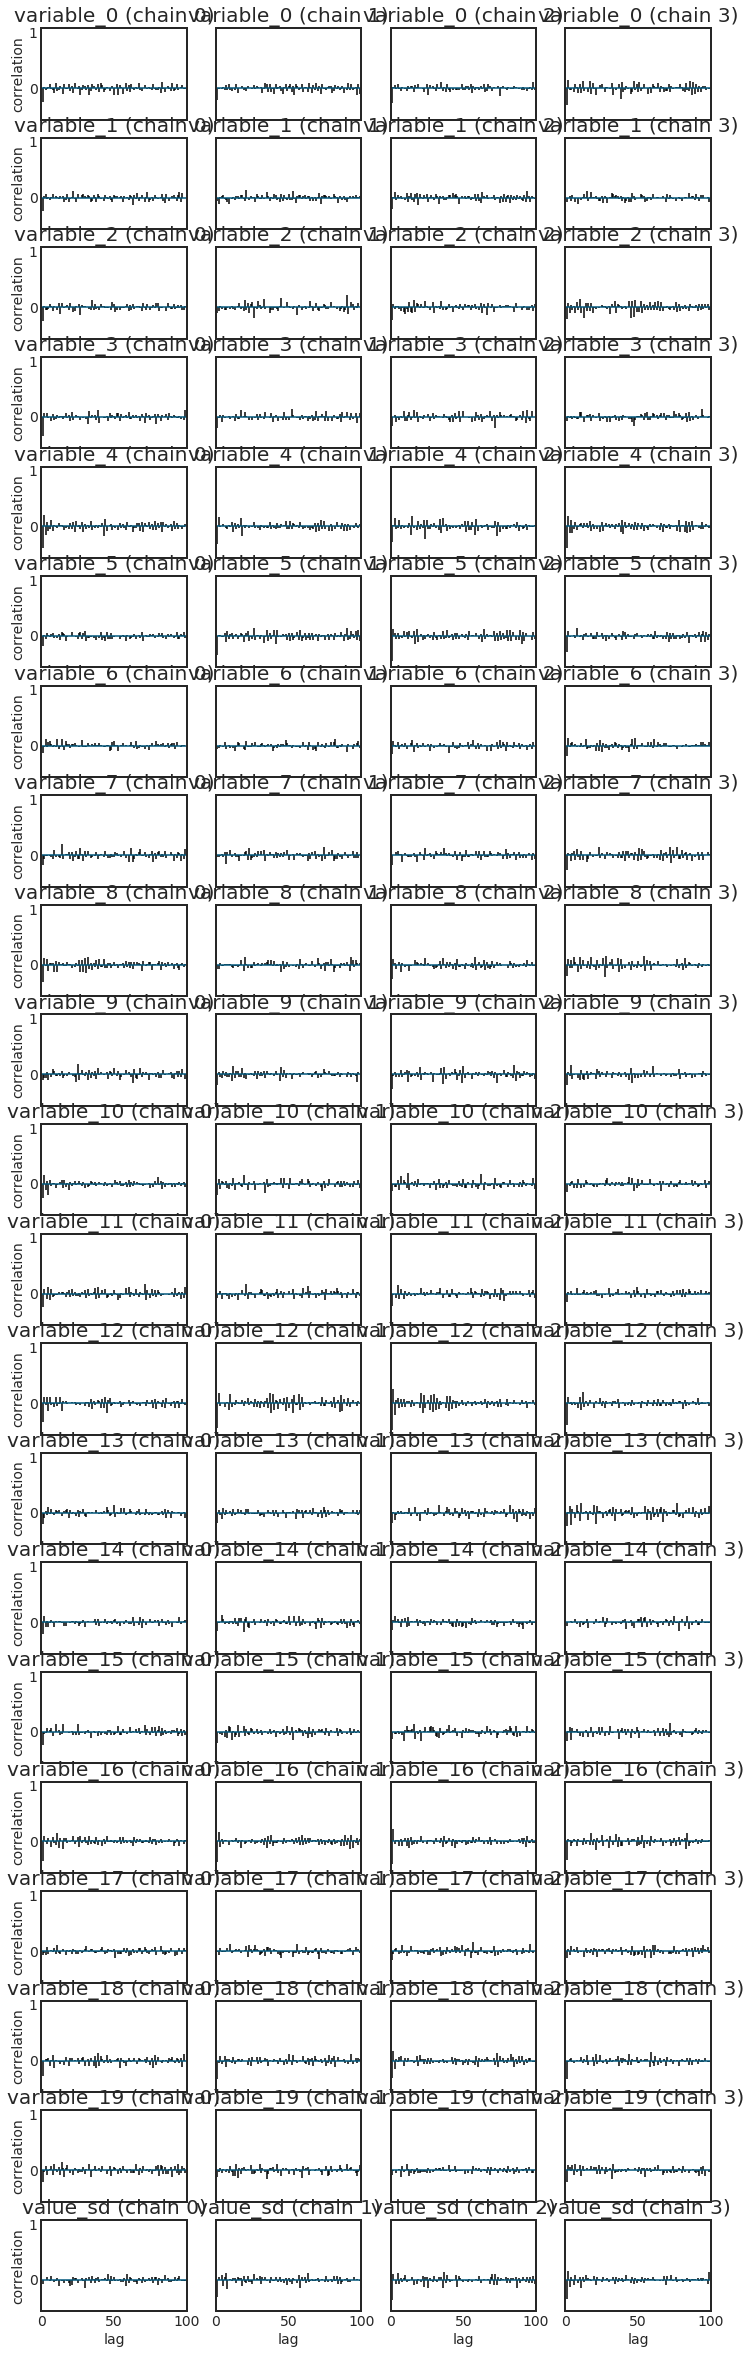

In [46]:
_ = pm.autocorrplot(model.backend.trace)

## Summary table

You can use both pm.summary(model.backend.trace) and results.summary() to get the final summary table, but one preserves the original categorical variable names unlike the other.

In [82]:
pm.summary(model.backend.trace).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
variable__0,3.504011,0.142744,0.003269,3.211766,3.763263,1919.499774,1.001761
variable__1,6.078238,0.148353,0.003510,5.789543,6.353640,1503.384199,1.000113
variable__2,4.360439,0.139198,0.003021,4.089456,4.638124,2001.264725,1.000380
variable__3,4.397622,0.149611,0.003053,4.124128,4.687747,1826.468064,0.999453
variable__4,7.200271,0.147944,0.003107,6.928753,7.497829,2290.058582,0.998995


In [83]:
results.summary().head()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
variable[treatment_a],3.504011,0.142804,3.211766,3.763263,1200,1.001761
variable[treatment_b],6.078238,0.148415,5.789543,6.353640,1200,1.000113
variable[treatment_c],4.360439,0.139256,4.089456,4.638124,1200,1.000380
variable[treatment_d],4.397622,0.149673,4.124128,4.687747,1200,0.999453
variable[treatment_e],7.200271,0.148006,6.928753,7.497829,1200,0.998995


Function syntax for calculating additional statistics for the summary tables is a bit different.

When using PyMC backend the functions are taking an array of resulting samples. See [here](https://docs.pymc.io/api/stats.html) and [here](https://docs.pymc.io/api/diagnostics.html) for details and list of statistics included with PyMC3.

In [70]:
def trace_median(x):
    '''median of the sample'''
    return pd.Series(np.median(x, 0), name='median')

def trace_prob(x, thresh):
    '''fraction of posterior distribution above certain threshold'''
    return pd.Series((x > thresh).sum(0)/len(x)*100, name = 'win')

In [79]:
summary_pymc = pm.summary(model.backend.trace,
          stat_funcs = [trace_median, 
                        lambda x: trace_prob(x, thresh = mu.value), 
                        ], 
        extend = True)

In [80]:
summary_pymc.head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,median,win,n_eff,Rhat
variable__0,3.504011,0.142744,0.003269,3.211766,3.763263,3.503465,0.0,1919.499774,1.001761
variable__1,6.078238,0.148353,0.003510,5.789543,6.353640,6.080346,100.0,1503.384199,1.000113
variable__2,4.360439,0.139198,0.003021,4.089456,4.638124,4.359982,0.0,2001.264725,1.000380
variable__3,4.397622,0.149611,0.003053,4.124128,4.687747,4.403297,0.0,1826.468064,0.999453
variable__4,7.200271,0.147944,0.003107,6.928753,7.497829,7.199443,100.0,2290.058582,0.998995


When using Bambi the functions for calculating additional stats should be able to work directly with sampling output - 'results' in our case. Also see [here](https://github.com/bambinos/bambi/blob/master/bambi/diagnostics.py) for more details on how different stats are implemented in bambi.

In [73]:
def mcmc_median(mcmc):
    data = mcmc.data.copy()
    median = np.median(data.reshape((data.shape[0]*data.shape[1], -1)),
         0)
    return pd.DataFrame({'median': median}, index=mcmc.levels)

def mcmc_prob(mcmc, thresh):
    data = mcmc.data.copy()
    data = data.reshape((data.shape[0]*data.shape[1], -1))
    p_positive = (data > thresh).sum(0)/data.shape[0]*100
    return pd.DataFrame({'win': p_positive}, index=mcmc.levels)

In [74]:
summary_bambi = results.summary(diagnostics=[mcmc_median, 
                                   lambda x: mcmc_prob(x, thresh = mu.value),
                                  'effective_n', 'gelman_rubin'])

In [81]:
summary_bambi.head()

,mean,sd,hpd0.95_lower,hpd0.95_upper,median,win,effective_n,gelman_rubin
variable[treatment_a],3.504011,0.142804,3.211766,3.763263,3.503465,0.0,1200,1.001761
variable[treatment_b],6.078238,0.148415,5.789543,6.353640,6.080346,100.0,1200,1.000113
variable[treatment_c],4.360439,0.139256,4.089456,4.638124,4.359982,0.0,1200,1.000380
variable[treatment_d],4.397622,0.149673,4.124128,4.687747,4.403297,0.0,1200,0.999453
variable[treatment_e],7.200271,0.148006,6.928753,7.497829,7.199443,100.0,1200,0.998995


## Useful references

* [Bambi User Guide](https://github.com/bambinos/bambi)

* [Bayesian modelling cookbook](https://eigenfoo.xyz/bayesian-modelling-cookbook/)

* [Prior choice recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

* [Tutorial on linear regression in PyMC3](https://docs.pymc.io/notebooks/GLM-linear.html)

* [Diagnosing biased Inference with Divergences](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html) 
